In [235]:
import logging
import pandas as pd
import numpy as np
from pytplot import (
    time_string,
    time_double,
)
from pyspedas.projects.noaa.config import CONFIG
from pyspedas.utilities.dailynames import dailynames
from pyspedas.utilities.download import download


def kp_return_fraction(value):
    value = np.array(value, dtype=np.float64)
    kp_lhs = value // 10
    kp_rhs_times_3 = value % 10
    kp_rhs = kp_rhs_times_3 // 3.0
    return kp_lhs + kp_rhs / 3.0


def convert_to_float_or_int(a, outtype="int"):
    ans = []
    for v in a:
        try:
            if outtype == "float":
                ans.append(float(v))
            else:  # outtype == "int"
                ans.append(int(v))
        except ValueError:
            ans.append(0)
    return ans


def load_kp_to_df(
    trange,
    files=[],
    datatype=[],
):
    vars = []

    if files is None or len(files) == 0:
        logging.error("No files specified")
        return vars
    elif not isinstance(files, list):
        files = [files]

    if datatype is None or datatype == [] or len(datatype) == 0:
        datatype = [
            "Kp",
        ]
    elif not isinstance(datatype, list):
        datatype = [datatype]
    datatype = [d.lower() for d in datatype]

    # Each line in the files contains data for one day.
    # The first 3 quantities are measured every 3 hours (8 measurements per day).
    kpdata = []
    kptimes = []
    daytimes = []

    for kpfile in files:
        # Example line contained in these files:
        # 1701012502 73337272323302017210 18 22 12  9  9 15  7  6 120.73---070.10
        # Line length is 73 for NOAA files and 63 for WDC files (both counts include \n).

        with open(kpfile, "r") as f:
            for line in f:
                if len(line) < 63 or line.startswith("#") or line.startswith(" "):
                    # Skip lines that are less than 63 characters long (62 data and \n)
                    continue

                # Get datetimes (0:6 characters)
                year = line[0:2]
                if "00" <= year <= "69":
                    year = "20" + year
                else:
                    year = "19" + year
                month = line[2:4]
                day = line[4:6]
                ymd = year + "-" + month + "-" + day
                daytimes.append(time_double(ymd))
                for k in range(8):
                    dd = time_double(ymd + " " + "{:02d}".format(k * 3) + ":00:00")
                    kptimes.append(dd)
                for k in range(8):
                    kpdata.append(line[12 + 2 * k : 14 + 2 * k])

    # Check for empty data set. If empty, return.
    if len(kptimes) == 0:
        logging.error("No data found.")
        return vars
    if (
        len(trange) == 2
        and trange[0] != 0
        and time_double(trange[1]) > time_double(trange[0])
        and (
            time_double(trange[1]) < kptimes[0] or time_double(trange[0]) > kptimes[-1]
        )
    ):
        logging.error("No data found in time range.")
        return vars
    
    vars = pd.DataFrame({'DateTime': kptimes, 'KP': kp_return_fraction(kpdata)})
    vars['DateTime'] = pd.to_datetime(vars['DateTime'], unit='s')
    
    return vars


def noaa_load_kp(
    trange
):
    vars = []

    if len(trange) == 2:
        trangestr = time_string(time_double(trange))
        start_year = int(trangestr[0][0:4])
        end_year = int(trangestr[1][0:4])
    else:
        logging.error("Invalid time range")
        return
    if end_year > start_year + 3:  # Limit to 4 years
        end_year = start_year + 3
        trange[1] = str(end_year) + "-12-31/00:00:00"
        logging.warning(
            "Time limit is 4 years, new time range is " + trange[0] + " to " + trange[1]
        )
    elif end_year < start_year:
        end_year = start_year
        trange[1] = str(end_year) + "-12-31/00:00:00"
        logging.warning(
            "End time is before start time, new time range is "
            + trange[0]
            + " to "
            + trange[1]
        )

    # Remote site and directory
    
    remote_data_dir = CONFIG['gfz_remote_data_dir']
    pathformat = "Kp_def%Y.wdc"
    
    logging.info("Loading geomagnetic index data from " + remote_data_dir)
    remote_names = dailynames(file_format=pathformat, trange=trange)
    files = download(
        remote_file=remote_names,
        remote_path=remote_data_dir,
    )

    if len(files) == 0:
        logging.error("No files found.")
        return vars

    vars = load_kp_to_df(
        trange=trange,
        files=list(set(files)),
    )

    return vars

18-May-25 11:34:18: Time limit is 4 years, new time range is 1991-01-01/00:00:00 to 1994-12-31/00:00:00
18-May-25 11:34:18: Loading geomagnetic index data from https://datapub.gfz-potsdam.de/download/10.5880.Kp.0001/Kp_definitive/
18-May-25 11:34:18: File is current: /Users/soumya/Desktop/cassini_hack/Kp_def1991.wdc
18-May-25 11:34:18: File is current: /Users/soumya/Desktop/cassini_hack/Kp_def1992.wdc
18-May-25 11:34:18: File is current: /Users/soumya/Desktop/cassini_hack/Kp_def1993.wdc
18-May-25 11:34:19: File is current: /Users/soumya/Desktop/cassini_hack/Kp_def1994.wdc


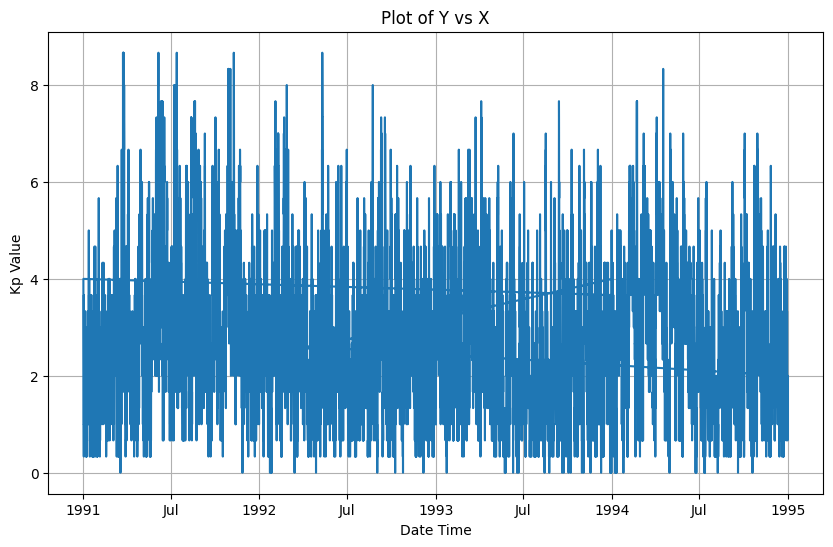

In [236]:
import matplotlib.pyplot as plt
df = noaa_load_kp(trange=["1991-01-01/00:00:00", "1995-01-01/23:59:59"])

df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Date'] = df['DateTime'].dt.date
# print(df.head(10))
plt.figure(figsize=(10, 6))
plt.plot(df['DateTime'], df['KP'])
plt.title('Plot of Y vs X')
plt.xlabel('Date Time')
plt.ylabel('Kp Value')
plt.grid(True)
plt.show()


In [237]:
df = df.groupby('DateTime')['KP'].mean().reset_index()
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Date'] = df['DateTime'].dt.date
print(df)

                 DateTime        KP        Date
0     1991-01-01 00:00:00  4.000000  1991-01-01
1     1991-01-01 03:00:00  2.666667  1991-01-01
2     1991-01-01 06:00:00  1.333333  1991-01-01
3     1991-01-01 09:00:00  1.000000  1991-01-01
4     1991-01-01 12:00:00  1.000000  1991-01-01
...                   ...       ...         ...
11683 1994-12-31 09:00:00  1.000000  1994-12-31
11684 1994-12-31 12:00:00  1.000000  1994-12-31
11685 1994-12-31 15:00:00  1.000000  1994-12-31
11686 1994-12-31 18:00:00  1.333333  1994-12-31
11687 1994-12-31 21:00:00  2.000000  1994-12-31

[11688 rows x 3 columns]


In [238]:
df.info()
df.head(20)
df = df.groupby('Date')['KP'].mean().reset_index()
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  11688 non-null  datetime64[ns]
 1   KP        11688 non-null  float64       
 2   Date      11688 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 274.1+ KB


,Date,KP
0,1991-01-01,1.458333
1,1991-01-02,2.416667
2,1991-01-03,2.333333
3,1991-01-04,1.916667
4,1991-01-05,1.958333
...,...,...
1456,1994-12-27,2.583333
1457,1994-12-28,2.083333
1458,1994-12-29,2.708333
1459,1994-12-30,1.750000


In [239]:
istd = pd.read_csv('decoded_stroke_data.csv')

istd.rename(columns={'Decoded_Date': 'Date'}, inplace=True)
istd['Date'] = pd.to_datetime(istd['Date'])
istd['Date'] = istd['Date'].dt.date

merged = pd.merge(df, istd, on='Date', how='outer')

istd.head()


18-May-25 11:34:19: /var/folders/fc/vy5m47nj62b3nk4p56wsjwr40000gn/T/ipykernel_34332/2541543764.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  istd = pd.read_csv('decoded_stroke_data.csv')



,HOSPNUM,RDELAY,RCONSC,SEX,AGE,RSLEEP,RATRIAL,RCT,RVISINF,RHEP24,...,H14,ISC14,NK14,STRK14,HTI14,PE14,DVT14,TRAN14,NCB14,Date
0,1,17,D,M,69,Y,NaN,Y,Y,NaN,...,0,0,0,0,0,0,0,0,0,1991-01-04
1,1,10,F,M,76,Y,NaN,Y,N,NaN,...,0,0,0,0,0,0,0,0,0,1991-01-07
2,1,43,F,F,71,N,NaN,Y,N,NaN,...,0,0,0,0,0,0,0,0,0,1991-01-03
3,1,6,F,M,81,N,NaN,N,N,NaN,...,0,0,0,0,0,0,0,0,0,1991-01-07
4,4,20,F,M,78,N,NaN,N,N,NaN,...,0,0,0,0,0,0,0,0,0,1991-02-06


In [240]:
merged

,Date,KP,HOSPNUM,RDELAY,RCONSC,SEX,AGE,RSLEEP,RATRIAL,RCT,...,DEAD8,H14,ISC14,NK14,STRK14,HTI14,PE14,DVT14,TRAN14,NCB14
0,1991-01-01,1.458333,4.0,27.0,F,M,71.0,N,NaN,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1991-01-01,1.458333,1.0,32.0,F,M,71.0,N,NaN,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1991-01-01,1.458333,2.0,35.0,D,M,65.0,Y,NaN,Y,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1991-01-01,1.458333,15.0,10.0,F,F,84.0,N,NaN,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1991-01-01,1.458333,5.0,28.0,F,M,72.0,N,NaN,Y,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20814,1994-12-27,2.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20815,1994-12-28,2.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20816,1994-12-29,2.708333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20817,1994-12-30,1.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
date_counts = merged['Date'].value_counts().reset_index()
date_counts.columns = ['Date', 'Count']

# Sort by date
date_counts = date_counts.sort_values('Date')
date_counts.tail

merged = pd.merge(merged, date_counts, on='Date', how='inner')
merged = merged[['Date','KP','Count']]
merged = merged.drop_duplicates()
merged

,Date,KP,Count
0,1991-01-01,1.458333,322
322,1991-01-02,2.416667,585
907,1991-01-03,2.333333,526
1433,1991-01-04,1.916667,531
1964,1991-01-05,1.958333,462
...,...,...,...
20814,1994-12-27,2.583333,1
20815,1994-12-28,2.083333,1
20816,1994-12-29,2.708333,1
20817,1994-12-30,1.750000,1


18-May-25 11:34:19: /Users/soumya/Desktop/cassini_hack/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Unique values in target variable: [  1 102 107 115 129 145 147 149 159 167 175 178 180 181 188 191 192 194
 203 207 209 211 213 214 215 225 227 228 229 231 235 237 239 240 243 249
 252 254 255 260 262 263 264 268 269 270 272 273 276 277 282 284 290 292
 295 298 301 306 322 325 329 333 334 350 365 462 505 526 531 585]
Number of unique values: 70


18-May-25 11:34:19: /Users/soumya/Desktop/cassini_hack/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

18-May-25 11:34:19: /Users/soumya/Desktop/cassini_hack/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

18-May-25 11:34:19: /Users/soumya/Desktop/cassini_hack/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame


Multiclass Classification Report:
               precision    recall  f1-score   support

           1       0.96      1.00      0.98       280
         115       0.00      0.00      0.00         1
         159       0.00      0.00      0.00         1
         188       0.00      0.00      0.00         1
         192       0.00      0.00      0.00         1
         214       0.00      0.00      0.00         1
         228       0.00      0.00      0.00         1
         243       0.00      0.00      0.00         1
         263       0.00      0.00      0.00         1
         277       0.00      0.00      0.00         1
         282       0.00      0.00      0.00         1
         292       0.00      0.00      0.00         1
         295       0.00      0.00      0.00         1
         325       0.00      0.00      0.00         1

    accuracy                           0.96       293
   macro avg       0.07      0.07      0.07       293
weighted avg       0.91      0.96      0.93 

<Figure size 1000x600 with 0 Axes>

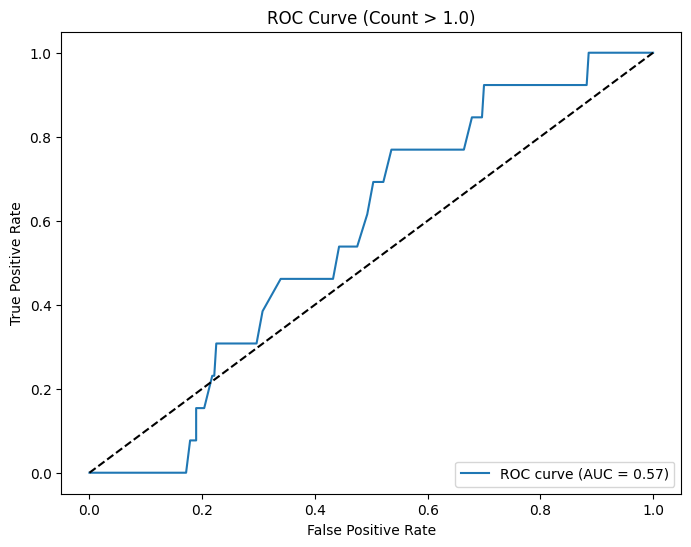

<Figure size 1000x600 with 0 Axes>

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Assuming df is your DataFrame with KP and Count columns
# Clean the data
df = merged[['KP', string]].copy()
df = df.dropna()  # Drop rows where KP or Count is NaN
df[string] = df[string].astype(int)  # Ensure Count is integer

# Feature
X = df[['KP']].values.reshape(-1, 1)
y = df[string].values

# Check the unique values in y
unique_values = np.unique(y)
print(f"Unique values in target variable: {unique_values}")
print(f"Number of unique values: {len(unique_values)}")

# Option 1: If you want to treat this as a multiclass classification problem
# This is appropriate if Count represents different categories

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation for multiclass
print("\nMulticlass Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot the decision boundaries or probability curves
plt.figure(figsize=(10, 6))
x_range = np.linspace(X.min() - 0.5, X.max() + 0.5, 1000).reshape(-1, 1)
probs = model.predict_proba(x_range)

# Plot probability for each class
# for i, class_value in enumerate(model.classes_):
#     plt.plot(x_range, probs[:, i], label=f'Class {class_value}')

# plt.scatter(X, y, c=y, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
# plt.colorbar(label='Count Value')
# plt.xlabel('KP')
# plt.ylabel('Probability')
# plt.title('Multinomial Logistic Regression Probability Curves')
# plt.legend()
# plt.tight_layout()
# plt.show()

# Option 2: If you want to convert to binary classification
# For example, if you want to predict whether Count is above a certain threshold
threshold = np.median(y)  # You can adjust this threshold based on your needs
y_binary = (y > threshold).astype(int)
print(f"\nUsing threshold {threshold} to convert to binary classification")
print(f"Class distribution after binarization: {np.bincount(y_binary)}")

# Train/test split for binary classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)

# Binary logistic regression model
binary_model = LogisticRegression()
binary_model.fit(X_train_bin, y_train_bin)

# Predictions
y_pred_bin = binary_model.predict(X_test_bin)
y_prob_bin = binary_model.predict_proba(X_test_bin)[:, 1]

# Evaluation for binary classification
print("\nBinary Classification Report:\n", classification_report(y_test_bin, y_pred_bin))
print("Confusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_bin))

# Now ROC curve will work for the binary case
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test_bin, y_prob_bin)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Count > {threshold})')
plt.legend(loc='lower right')
plt.show()

# Plot the logistic curve for binary classification
plt.figure(figsize=(10, 6))
x_range = np.linspace(X.min() - 0.5, X.max() + 0.5, 1000).reshape(-1, 1)
y_prob_range = binary_model.predict_proba(x_range)[:, 1]

# plt.scatter(X, y_binary, alpha=0.5, edgecolors='w', linewidth=0.5)
# plt.plot(x_range, y_prob_range, 'r-', linewidth=2)
# plt.xlabel('KP')
# plt.ylabel(f'Probability (Count > {threshold})')
# plt.title('Binary Logistic Regression')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()